## Imports



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper 
from pycox.models import MTLR
from pycox.evaluation import EvalSurv

import torch # For building the networks 
from sklearn.model_selection import KFold, GridSearchCV
from estimators import MLTREstimator
import torchtuples as tt 
from collections import defaultdict

In [2]:
# Hyper-parameters
test_size = 0.2
train_size = 0.8
assert test_size + train_size == 1, "total size is not equal to 1"

In [3]:
# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed);

## Dataset

We load data from an Iranian Institution

The `duration` column gives the observed times and the `event` column contains indicators of whether the observation is an event (1) or a censored observation (0).

In [4]:
train_dataset_fp ='finaldata-June26.csv'
df = pd.read_csv(train_dataset_fp)
df.head(100)

,event,time,diagnosic-age,edjucation,marital-status,G,AB,BF,FH,Surgery,T,N,stage,Path,Grade,LVI,hormone subgroup,CT,RT,HT
0,0,334.2,46,2,2,2,1,1,0,2,1,2,3,1,2,0,2,1,1,1
1,0,328.9,35,1,2,2,0,1,0,1,3,0,2,1,2,0,4,1,1,1
2,0,310.4,41,2,2,2,0,1,0,2,1,2,3,1,2,1,2,1,1,1
3,0,309.7,48,2,2,1,0,1,0,2,2,0,2,1,2,0,2,1,0,1
4,1,299.6,47,4,2,3,0,2,2,2,2,0,2,1,2,0,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,211.1,47,2,2,2,1,1,1,2,1,0,1,1,3,0,2,0,0,1
96,0,210.8,36,1,2,0,0,0,0,2,1,0,1,1,1,0,2,1,1,1
97,0,210.6,54,1,2,3,1,1,2,2,2,0,2,1,2,0,2,0,1,1
98,0,208.9,41,1,2,1,0,1,0,2,2,0,2,1,2,0,4,1,1,1


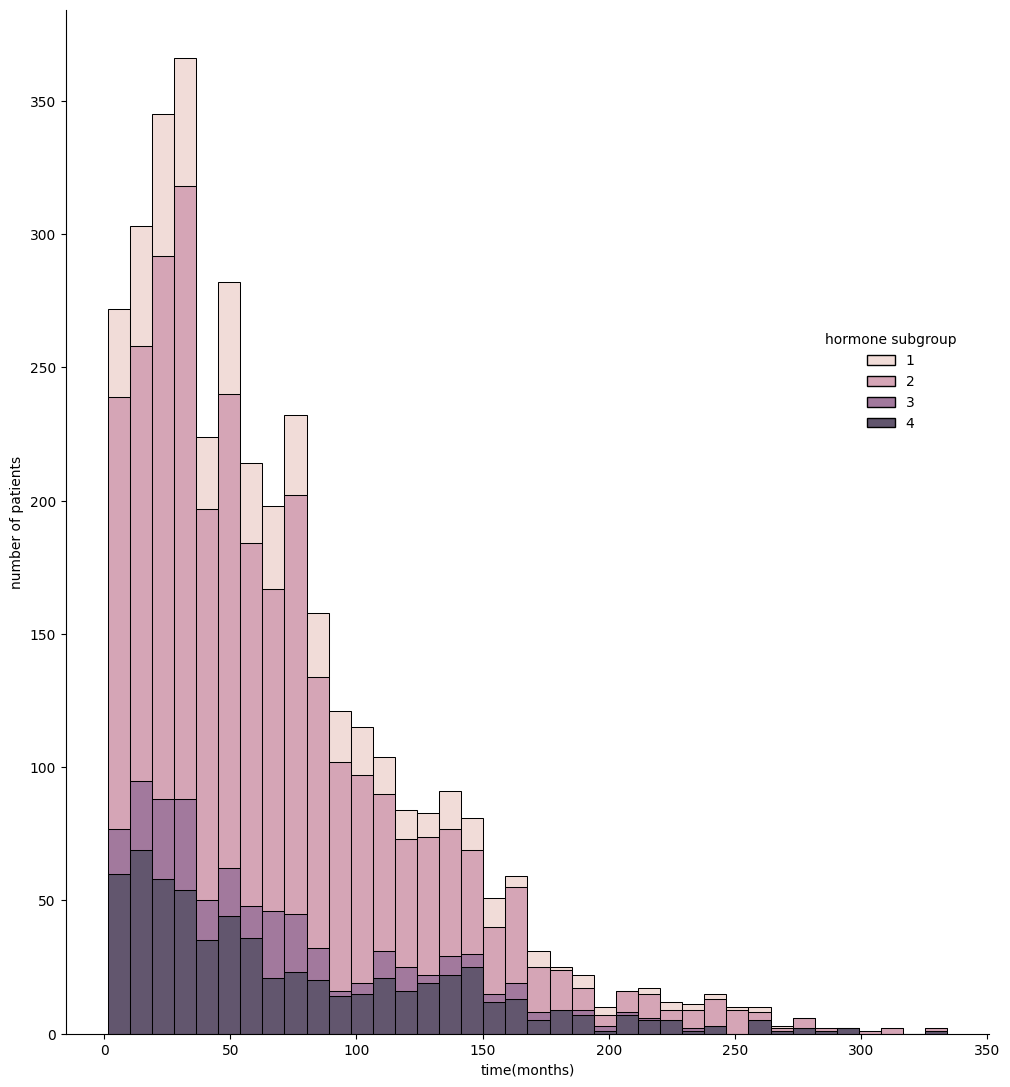

In [5]:
import seaborn as sns

s = sns.displot(df, x="time", hue="hormone subgroup", multiple="stack")
s.set(xlabel='time(months)', ylabel='number of patients')
plt.gcf().set_size_inches(15, 12)
sns.move_legend(s, "center", bbox_to_anchor=(.66, .66))  

## Train-Test-Spilit

In [8]:
df_train, df_test = train_test_split(df, test_size=test_size, random_state=seed, stratify=df["hormone subgroup"])

## Feature transforms


The dataset has 18 covariates.
We will standardize the 12 categorical covariates, and leave the binary covariates as is.
Note that PyTorch require variables of type `'float32'`.

Here we use the `sklearn_pandas.DataFrameMapper` to make feature mappers, but this has nothing to do the the `pycox` package.

In [9]:
cols_standardize = ['diagnosic-age',
                    'edjucation', 
                    'G',
                    'BF',
                    'FH',
                    'T',
                    'N',
                    'stage',
                    'Grade',
                    'CT','RT','hormone subgroup']
cols_leave = ['marital-status', 'AB', 'Path', 'LVI', 'Surgery', 'HT']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [10]:
# apply scalar transformation!
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [11]:
# Checking the distribution of `hormone subgroup`
feature_index = 11 # hormone subgroup

def get_feature_distribution(feature_index, dataset):
    filtered_individuals = defaultdict(list)
    dataset_reverse = standardize[feature_index][1].inverse_transform(dataset)

    for i in range(len(dataset)):
        individual = dataset_reverse[i]
        filtered_individuals[int(individual[feature_index])].append(i)
    print(sorted([(k, len(v)) for k, v in filtered_individuals.items()]))
    return filtered_individuals
get_feature_distribution(feature_index, x_test);
get_feature_distribution(feature_index, x_train);

[(1, 101), (2, 435), (3, 54), (4, 126)]
[(1, 402), (2, 1740), (3, 216), (4, 506)]


## Label transforms

The survival methods require individual label transforms, so we have included a proposed `label_transform` for each method.
For most of them the `label_transform` is just a shorthand for the class `pycox.preprocessing.label_transforms.LabTransDiscreteTime`.

The `LogisticHazard` is a discrete-time method, meaning it requires discretization of the event times to be applied to continuous-time data.
We let `num_durations` define the size of this (equidistant) discretization grid, meaning our network will have `num_durations` output nodes.

In [12]:
# events!
np.unique(df['event'], return_counts=True)

(array([0, 1], dtype=int64), array([3146,  434], dtype=int64))

In [13]:
num_durations = 10 # discretization

label_translator = MTLR.label_transform(num_durations)


get_features = lambda df: (df['time'].values, df['event'].values)
label_translator.fit(*get_features(df_train))

The `label_translator.cuts` contains the discretization grid. This will later be used to obtain the right time-scale for survival predictions.

In [14]:
label_translator.cuts, len(label_translator.cuts)

(array([  0.        ,  37.13333333,  74.26666667, 111.4       ,
        148.53333333, 185.66666667, 222.8       , 259.93333333,
        297.06666667, 334.2       ]),
 10)

Now, `y_train` is a tuple with the indices of the discretized times, in addition to event indicators.

In [15]:
df_train.columns

Index(['event', 'time', 'diagnosic-age', 'edjucation', 'marital-status', 'G',
       'AB', 'BF', 'FH', 'Surgery', 'T', 'N', 'stage', 'Path', 'Grade', 'LVI',
       'hormone subgroup', 'CT', 'RT', 'HT'],
      dtype='object')

In [16]:
# As an example-> 
# sample_index = 10
# sample_duration_index = y_train[0][sample_index]
# sample_event = y_train[1][sample_index]
# sample_time = df_train["time"].values[sample_index]
# print(sample_time, sample_duration_index, sample_event)
# print(f"based on the label_translator.cuts sample: {sample_index} is in cuts with index: {sample_duration_index}")

# K-Fold

In [17]:
params = {  # search params
        'learning_rate': [0.1, 0.01, 0.001],
        'num_nodes': [[32, 32], [32, 64], [32, 64, 128], [32, 64, 128, 256]],
        'dropout': [0.0, 0.1, 0.2, 0.3],
        'batch_size': [256],
    }

cv = 5

In [18]:
estimator = MLTREstimator(label_translator, x_train.shape[1])
gs = GridSearchCV(estimator, params, refit=True, cv=KFold(n_splits=cv), verbose=1, n_jobs=5)

In [19]:
stack = lambda duration, event:np.hstack([duration.reshape((-1, 1)), event.reshape((-1, 1))])
y_train = stack(*get_features(df_train))

In [20]:
gs.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0:	[1s / 1s],		train_loss: 3.1540,	val_loss: 3.9558
1:	[0s / 2s],		train_loss: 1.4514,	val_loss: 1.4052
2:	[0s / 2s],		train_loss: 1.1166,	val_loss: 0.8578
3:	[0s / 2s],		train_loss: 0.6462,	val_loss: 0.5031
4:	[0s / 2s],		train_loss: 0.4819,	val_loss: 0.4186
5:	[0s / 2s],		train_loss: 0.4576,	val_loss: 0.3387
6:	[0s / 2s],		train_loss: 0.3876,	val_loss: 0.4998
7:	[0s / 2s],		train_loss: 0.4305,	val_loss: 0.3618
8:	[0s / 3s],		train_loss: 0.4535,	val_loss: 0.3714
9:	[0s / 3s],		train_loss: 0.4801,	val_loss: 0.3703
10:	[0s / 3s],		train_loss: 0.3780,	val_loss: 0.3591
11:	[0s / 3s],		train_loss: 0.3448,	val_loss: 0.3758
12:	[0s / 3s],		train_loss: 0.3830,	val_loss: 0.3169
13:	[0s / 3s],		train_loss: 0.3367,	val_loss: 0.4228
14:	[0s / 3s],		train_loss: 0.3954,	val_loss: 0.3874
15:	[0s / 3s],		train_loss: 0.4081,	val_loss: 0.4538
16:	[0s / 4s],		train_loss: 0.3873,	val_loss: 0.3348
17:	[0s / 4s],		train_loss: 0.3794,	val_loss: 0

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=MLTREstimator(in_features=18,
                                     label_translator=<pycox.preprocessing.label_transforms.LabTransDiscreteTime object at 0x0000024F52D9A230>),
             n_jobs=5,
             param_grid={'batch_size': [256], 'dropout': [0.0, 0.1, 0.2, 0.3],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'num_nodes': [[32, 32], [32, 64], [32, 64, 128],
                                       [32, 64, 128, 256]]},
             verbose=1)

In [21]:
print(gs.best_score_, gs.best_params_)

0.7552311258775719 {'batch_size': 256, 'dropout': 0.0, 'learning_rate': 0.1, 'num_nodes': [32, 64, 128, 256]}


In [22]:
durations_test, events_test = get_features(df_test)

gs.score(x_test, np.hstack([durations_test.reshape((-1, 1)), events_test.reshape((-1, 1))]))

C:\Users\pooya\miniconda3\envs\torch_gpu\lib\site-packages\pycox\evaluation\eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0.7651818681750334

In [49]:
estimator = MLTREstimator(label_translator, x_train.shape[1], **gs.best_params_)

In [50]:
estimator.fit(x_train, y_train, verbose=True)

0:	[0s / 0s],		train_loss: 3.2985,	val_loss: 9.1005
1:	[0s / 0s],		train_loss: 1.3637,	val_loss: 2.1464
2:	[0s / 0s],		train_loss: 0.8821,	val_loss: 0.7908
3:	[0s / 0s],		train_loss: 0.6260,	val_loss: 0.4983
4:	[0s / 0s],		train_loss: 0.6032,	val_loss: 0.7455
5:	[0s / 0s],		train_loss: 0.4722,	val_loss: 0.3468
6:	[0s / 0s],		train_loss: 0.4188,	val_loss: 0.3966
7:	[0s / 1s],		train_loss: 0.4523,	val_loss: 0.3487
8:	[0s / 1s],		train_loss: 0.4308,	val_loss: 0.3622
9:	[0s / 1s],		train_loss: 0.4114,	val_loss: 0.3920
10:	[0s / 1s],		train_loss: 0.4638,	val_loss: 0.3618
11:	[0s / 1s],		train_loss: 0.4842,	val_loss: 0.6742
12:	[0s / 1s],		train_loss: 0.5517,	val_loss: 0.5672
13:	[0s / 1s],		train_loss: 0.4139,	val_loss: 0.3107
14:	[0s / 2s],		train_loss: 0.4551,	val_loss: 0.3981
15:	[0s / 2s],		train_loss: 0.4515,	val_loss: 0.3696
16:	[0s / 2s],		train_loss: 0.4253,	val_loss: 0.6092
17:	[0s / 2s],		train_loss: 0.4042,	val_loss: 0.9834
18:	[0s / 2s],		train_loss: 0.4084,	val_loss: 0.6268
19:

MLTREstimator(in_features=18,
              label_translator=<pycox.preprocessing.label_transforms.LabTransDiscreteTime object at 0x0000024F52D9A230>,
              learning_rate=0.1, num_nodes=[32, 64, 128, 256])

In [51]:
estimator.score_split(x_test, durations_test, events_test)

C:\Users\pooya\miniconda3\envs\torch_gpu\lib\site-packages\pycox\evaluation\eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


0.7395972451357792

In [52]:
model = estimator.model
log = model.log
model.net

MLPVanilla(
  (net): Sequential(
    (0): DenseVanillaBlock(
      (linear): Linear(in_features=18, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): DenseVanillaBlock(
      (linear): Linear(in_features=32, out_features=64, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): DenseVanillaBlock(
      (linear): Linear(in_features=64, out_features=128, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): DenseVanillaBlock(
      (linear): Linear(in_features=128, out_features=256, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Linear(in_features=256, out_features=10, 

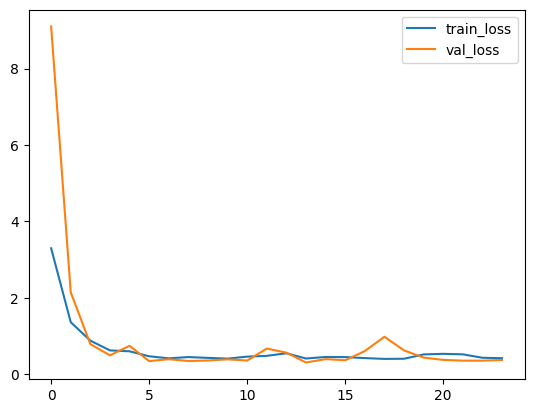

In [53]:
log.plot();

Next, we set the `batch_size` and the number of training `epochs`.

We also include the `EarlyStopping` callback to stop training when the validation loss stops improving.

In [54]:
log.to_pandas().val_loss.min()

0.3106600046157837

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

In [55]:
surv = model.predict_surv_df(x_test)
surv
# columns are sample indices, values are the probability of the events

,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
0.000000,0.999900,0.999771,0.999762,0.999675,0.999999,0.999819,0.999377,0.999334,0.999819,0.999532,...,0.999922,0.999445,0.999747,0.999571,0.999770,0.999731,9.999896e-01,1.000000e+00,0.999431,0.999983
37.133333,0.991486,0.983364,0.962004,0.939618,0.999824,0.976192,0.477319,0.875732,0.978423,0.889654,...,0.990765,0.845751,0.961193,0.937843,0.977083,0.981010,3.672419e-01,9.999825e-01,0.860060,0.999473
74.266667,0.974165,0.958402,0.900893,0.858371,0.999326,0.934867,0.251040,0.754299,0.943153,0.773880,...,0.969742,0.701605,0.899764,0.863028,0.940107,0.954724,2.255750e-01,9.999453e-01,0.723469,0.997938
111.400000,0.955617,0.931477,0.846782,0.778422,0.999125,0.892703,0.125300,0.645536,0.906666,0.670449,...,0.947137,0.588719,0.844775,0.786162,0.901862,0.925356,1.899377e-01,9.999445e-01,0.611646,0.996125
148.533333,0.933212,0.917774,0.784620,0.721106,0.991651,0.856063,0.050510,0.577013,0.868938,0.586721,...,0.926546,0.484544,0.790636,0.744499,0.874732,0.911474,3.734291e-03,2.792723e-01,0.516333,0.992576
185.666667,0.817762,0.859356,0.620847,0.584467,0.938702,0.727989,0.026795,0.454096,0.727766,0.435696,...,0.832420,0.339594,0.642803,0.640517,0.776670,0.855465,1.011014e-03,1.515802e-01,0.372042,0.949339
222.800000,0.465512,0.622077,0.241286,0.249890,0.820195,0.365672,0.002202,0.176954,0.359605,0.142992,...,0.498000,0.084536,0.269756,0.355111,0.458307,0.639420,2.086163e-06,1.427208e-01,0.104560,0.745531
259.933333,0.147200,0.445708,0.095294,0.138246,0.028172,0.165855,0.001691,0.115803,0.139358,0.076784,...,0.213954,0.044463,0.121517,0.250549,0.267380,0.492197,2.980232e-07,5.728006e-05,0.057459,0.147382
297.066667,0.025997,0.194680,0.020139,0.033435,0.001883,0.041494,0.000297,0.029210,0.023158,0.012784,...,0.065190,0.007401,0.030378,0.087889,0.091802,0.234629,0.000000e+00,2.980232e-07,0.010585,0.030786
334.200000,0.003340,0.051165,0.003751,0.006238,0.000254,0.007707,0.000069,0.005799,0.002863,0.001794,...,0.014490,0.001187,0.006320,0.021299,0.021658,0.067545,0.000000e+00,1.192093e-07,0.001775,0.004282


[(1, 101), (2, 435), (3, 54), (4, 126)]


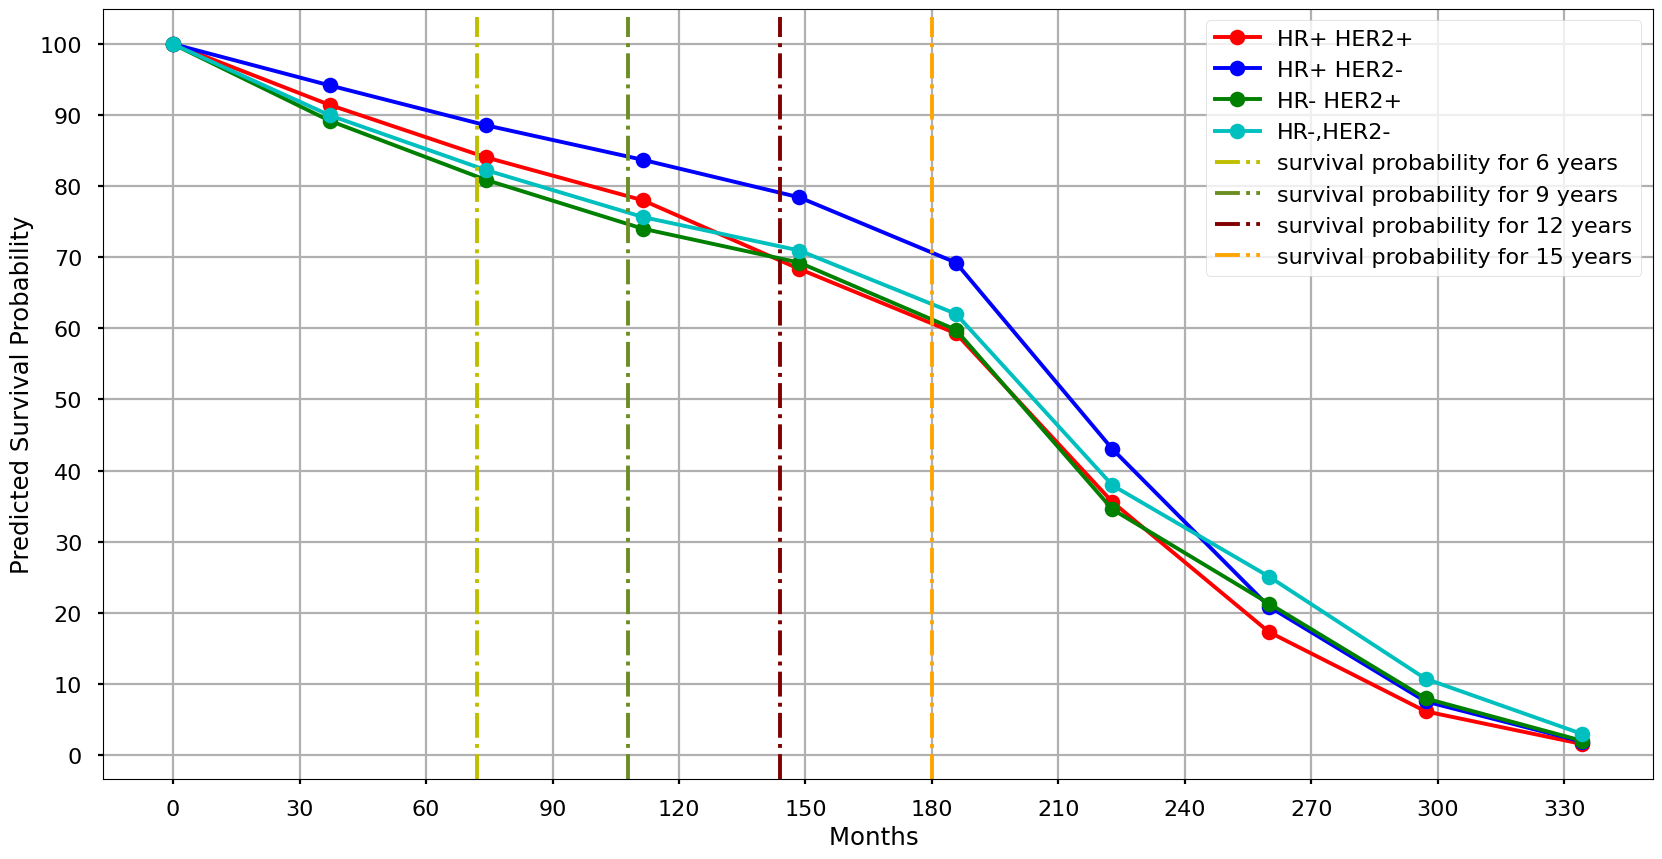

In [56]:
plt.figure(figsize=(20, 10))

test_filtered_individuals = get_feature_distribution(feature_index, x_test)
intervals = label_translator.cuts

avg_probs = dict()
values_of_individuals_subgroups = dict()

for hormone_group, individuals in test_filtered_individuals.items():
    no_of_individuals_subgroup = len(individuals)
    values_of_individuals_subgroup = []
    sum_of_individuals_subgroup = [0 for _ in range(label_translator.out_features)]
    for individual_index in individuals:
        for interval_index, interval_value in enumerate(intervals):
            sum_of_individuals_subgroup[interval_index] += surv[individual_index][interval_value]
            values_of_individuals_subgroup.append((interval_value, surv[individual_index][interval_value]))
    values_of_individuals_subgroups[hormone_group] = values_of_individuals_subgroup
    avg_probs[hormone_group] = [prob_sum / no_of_individuals_subgroup for prob_sum in sum_of_individuals_subgroup]

avg_prob_1, avg_prob_2, avg_prob_3, avg_prob_4 = avg_probs[1], avg_probs[2], avg_probs[3], avg_probs[4]

with plt.style.context('seaborn-poster'):
    plt.plot(intervals, avg_prob_1 , 'ro-', label='HR+ HER2+')
    plt.plot(intervals, avg_prob_2 , 'bo-', label='HR+ HER2-')
    plt.plot(intervals, avg_prob_3 , 'go-', label='HR- HER2+')
    plt.plot(intervals, avg_prob_4 , 'co-', label='HR-,HER2-')
    plt.axvline(x = 72, ymin = 0, ymax = 0.99, color = 'y', linestyle='dashdot',
            label = 'survival probability for 6 years')
    plt.axvline(x = 108, ymin = 0, ymax = 0.99, color = 'olivedrab', linestyle='dashdot',
            label = 'survival probability for 9 years')
    plt.axvline(x = 144, ymin = 0, ymax = 0.99, color = 'maroon', linestyle='dashdot',
            label = 'survival probability for 12 years')
    plt.axvline(x = 180, ymin = 0, ymax = 0.99, color = 'orange', linestyle='dashdot',
            label = 'survival probability for 15 years')
    plt.grid(True);
    plt.xticks(np.arange(0, 360, 30))
    plt.yticks(np.arange(0, 1.1, 0.1), np.arange(0, 110, 10))
    plt.xlabel('Months ')
    plt.ylabel('Predicted Survival Probability')
    plt.legend()


# surv.columns

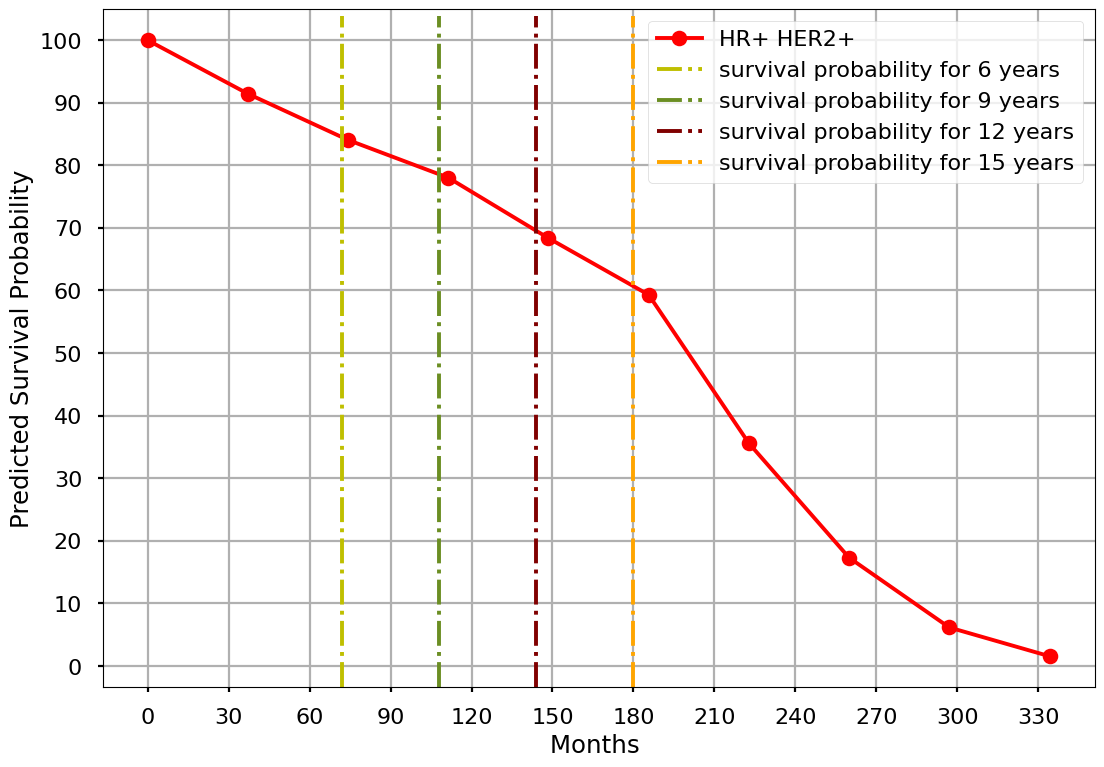

In [57]:
with plt.style.context('seaborn-poster'):
    plt.plot(intervals, avg_prob_1 , 'ro-', label='HR+ HER2+')
    plt.axvline(x = 72, ymin = 0, ymax = 0.99, color = 'y', linestyle='dashdot',
            label = 'survival probability for 6 years')
    plt.axvline(x = 108, ymin = 0, ymax = 0.99, color = 'olivedrab', linestyle='dashdot',
            label = 'survival probability for 9 years')
    plt.axvline(x = 144, ymin = 0, ymax = 0.99, color = 'maroon', linestyle='dashdot',
            label = 'survival probability for 12 years')
    plt.axvline(x = 180, ymin = 0, ymax = 0.99, color = 'orange', linestyle='dashdot',
            label = 'survival probability for 15 years')
    plt.grid(True);
    plt.xticks(np.arange(0, 360, 30))
    plt.yticks(np.arange(0, 1.1, 0.1), np.arange(0, 110, 10))
    plt.xlabel('Months ')
    plt.ylabel('Predicted Survival Probability')
    plt.legend()

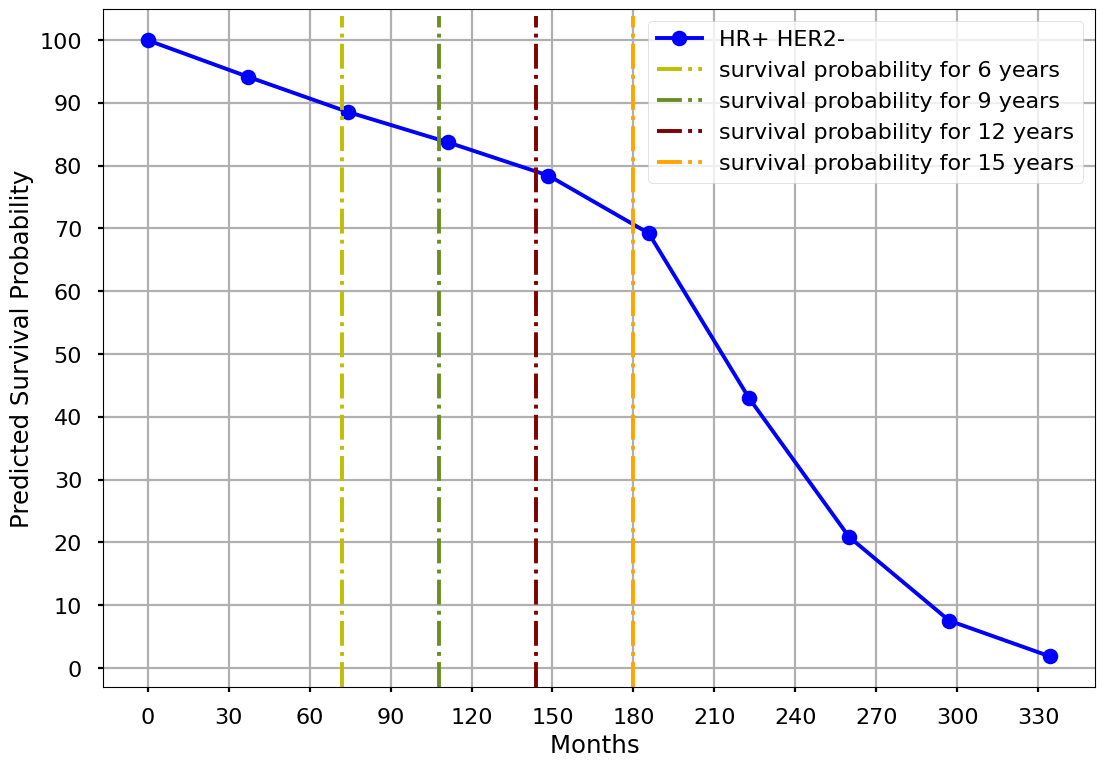

In [58]:
with plt.style.context('seaborn-poster'):
    plt.plot(intervals, avg_prob_2 , 'bo-', label='HR+ HER2-')
    plt.axvline(x = 72, ymin = 0, ymax = 0.99, color = 'y', linestyle='dashdot',
            label = 'survival probability for 6 years')
    plt.axvline(x = 108, ymin = 0, ymax = 0.99, color = 'olivedrab', linestyle='dashdot',
            label = 'survival probability for 9 years')
    plt.axvline(x = 144, ymin = 0, ymax = 0.99, color = 'maroon', linestyle='dashdot',
            label = 'survival probability for 12 years')
    plt.axvline(x = 180, ymin = 0, ymax = 0.99, color = 'orange', linestyle='dashdot',
            label = 'survival probability for 15 years')
    plt.grid(True);
    plt.xticks(np.arange(0, 360, 30))
    plt.yticks(np.arange(0, 1.1, 0.1), np.arange(0, 110, 10))
    plt.xlabel('Months ')
    plt.ylabel('Predicted Survival Probability')
    plt.legend()

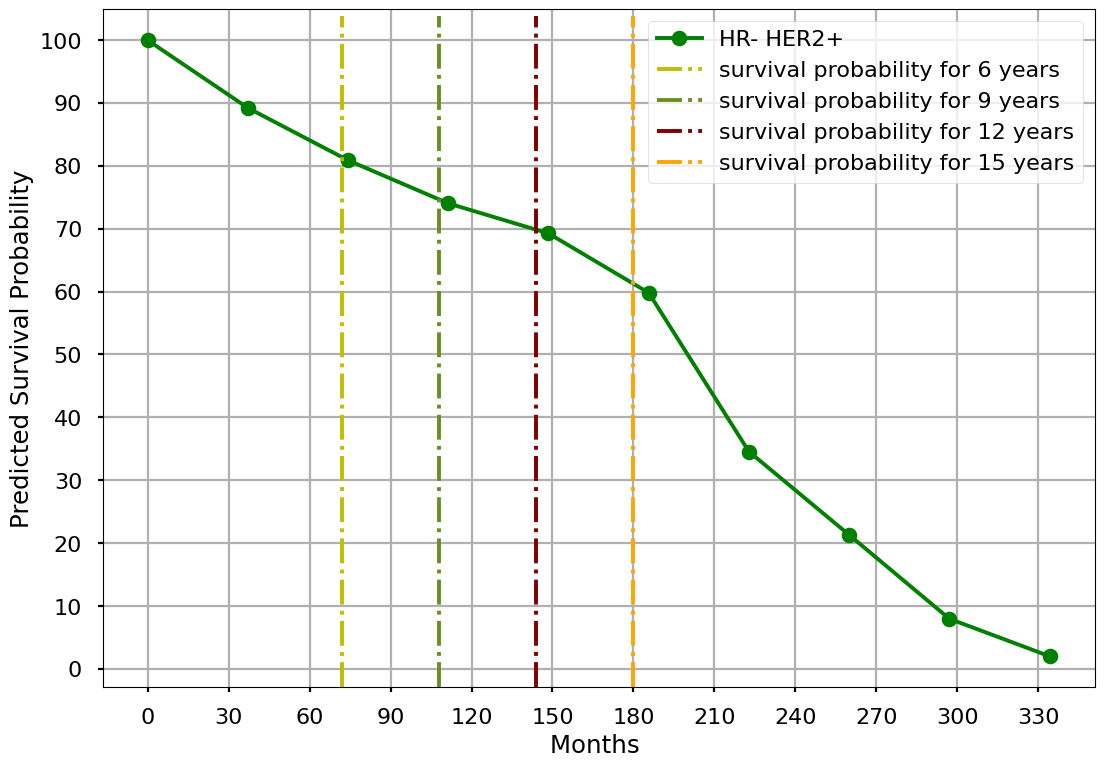

In [59]:
with plt.style.context('seaborn-poster'):
    plt.plot(intervals, avg_prob_3 , 'go-', label='HR- HER2+')
    plt.axvline(x = 72, ymin = 0, ymax = 0.99, color = 'y', linestyle='dashdot',
            label = 'survival probability for 6 years')
    plt.axvline(x = 108, ymin = 0, ymax = 0.99, color = 'olivedrab', linestyle='dashdot',
            label = 'survival probability for 9 years')
    plt.axvline(x = 144, ymin = 0, ymax = 0.99, color = 'maroon', linestyle='dashdot',
            label = 'survival probability for 12 years')
    plt.axvline(x = 180, ymin = 0, ymax = 0.99, color = 'orange', linestyle='dashdot',
            label = 'survival probability for 15 years')
    plt.grid(True);
    plt.xticks(np.arange(0, 360, 30))
    plt.yticks(np.arange(0, 1.1, 0.1), np.arange(0, 110, 10))
    plt.xlabel('Months ')
    plt.ylabel('Predicted Survival Probability')
    plt.legend()

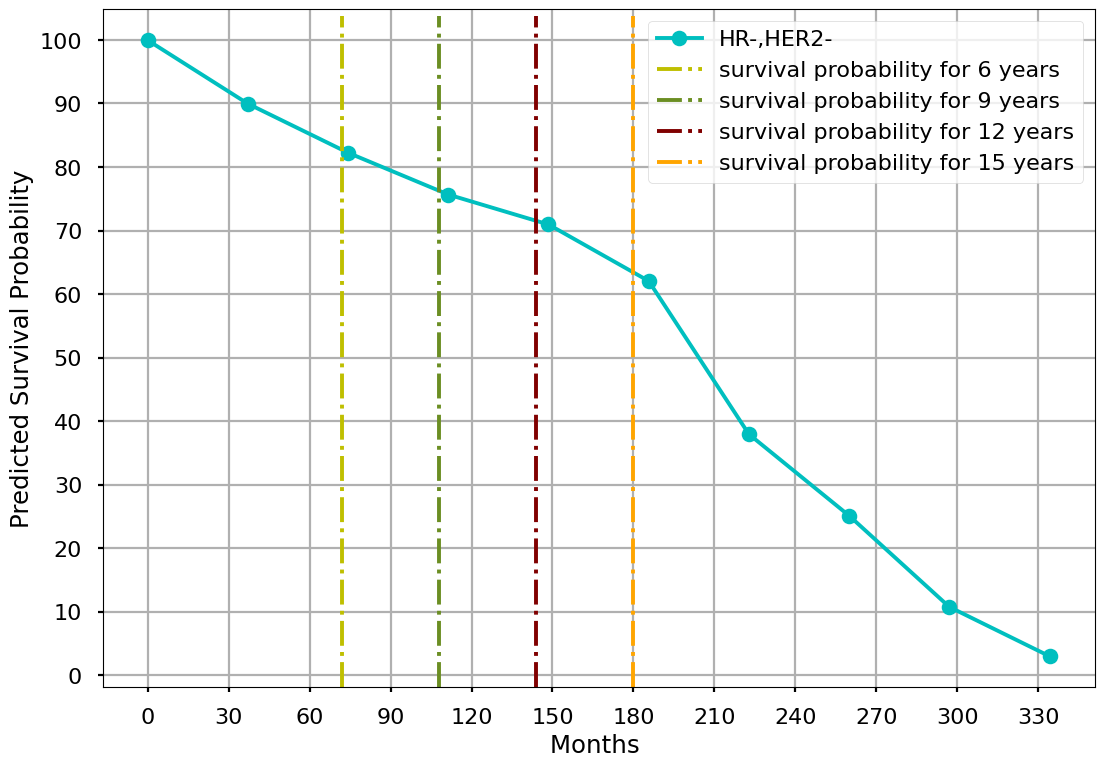

In [60]:
with plt.style.context('seaborn-poster'):
    plt.plot(intervals, avg_prob_4 , 'co-', label='HR-,HER2-')
    plt.axvline(x = 72, ymin = 0, ymax = 0.99, color = 'y', linestyle='dashdot',
            label = 'survival probability for 6 years')
    plt.axvline(x = 108, ymin = 0, ymax = 0.99, color = 'olivedrab', linestyle='dashdot',
            label = 'survival probability for 9 years')
    plt.axvline(x = 144, ymin = 0, ymax = 0.99, color = 'maroon', linestyle='dashdot',
            label = 'survival probability for 12 years')
    plt.axvline(x = 180, ymin = 0, ymax = 0.99, color = 'orange', linestyle='dashdot',
            label = 'survival probability for 15 years')
    plt.grid(True);
    plt.xticks(np.arange(0, 360, 30))
    plt.yticks(np.arange(0, 1.1, 0.1), np.arange(0, 110, 10))
    plt.xlabel('Months ')
    plt.ylabel('Predicted Survival Probability')
    plt.legend()

We can plot the survival estimates for the first 5 individuals.
Note that the time scale is correct because we have set `model.duration_index` to be the grid points.
We have, however, only defined the survival estimates at the 10 times in our discretization grid, so, the survival estimates is a step function

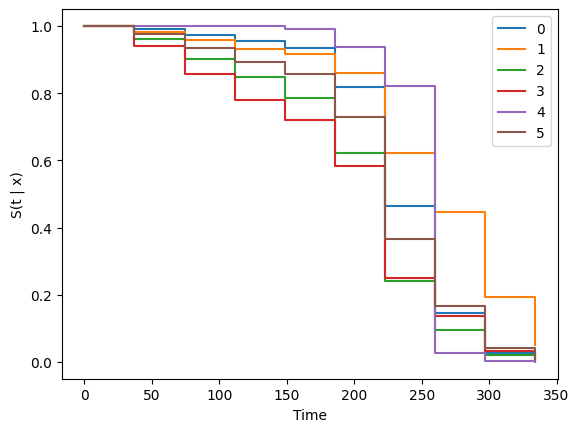

In [65]:
surv.iloc[:, :6].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

It is, therefore, often beneficial to [interpolate the survival estimates](https://arxiv.org/abs/1910.06724).
Linear interpolation (constant density interpolation) can be performed with the `interpolate` method. We also need to choose how many points we want to replace each grid point with. Her we will use 10.

In [66]:
surv = model.interpolate(10).predict_surv_df(x_test)

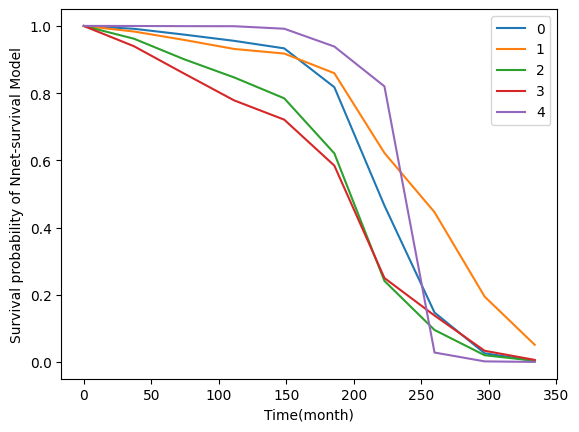

In [67]:
surv.iloc[:, :5].plot(drawstyle='default')
plt.ylabel('Survival probability of Nnet-survival Model')
_ = plt.xlabel('Time(month)')

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [68]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

C:\Users\pooya\miniconda3\envs\torch_gpu\lib\site-packages\pycox\evaluation\eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [69]:
ev.concordance_td('antolini')

0.7714667295152801

#### Brier Score

We can plot the the [IPCW Brier score](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5) for a given set of times.
Here we just use 100 time-points between the min and max duration in the test set.
Note that the score becomes unstable for the highest times. It is therefore common to disregard the rightmost part of the graph.

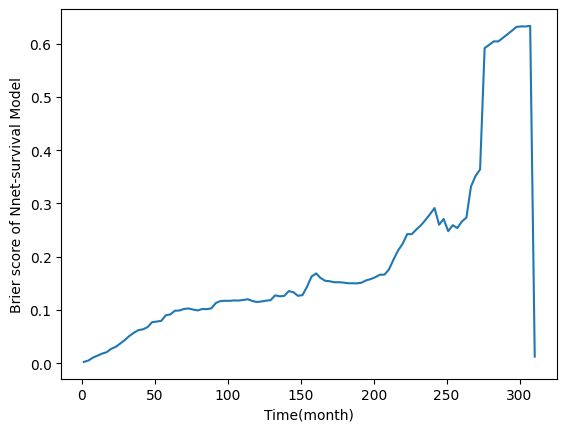

In [70]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score of Nnet-survival Model')
_ = plt.xlabel('Time(month)')

#### Negative binomial log-likelihood

In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

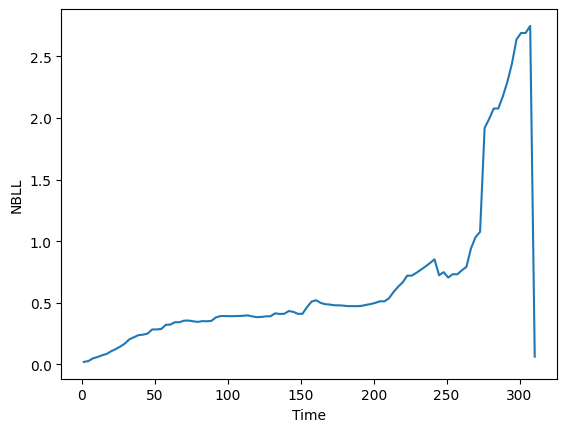

In [71]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). In practice this is done by numerical integration over a defined `time_grid`.

In [72]:
ev.integrated_brier_score(time_grid) 

0.1963944455879859

In [73]:
ev.integrated_nbll(time_grid) 

0.6613715035006934

*_:-)_*